In [1]:
import nbodykit.lab as nb
import numpy as np
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline


In [2]:
import numpy
def fftk(shape, boxsize, symmetric=True, finite=False, dtype=np.float64):
    """ return kvector given a shape (nc, nc, nc) and boxsize 
    """
    k = []
    for d in range(len(shape)):
        kd = numpy.fft.fftfreq(shape[d])
        kd *= 2 * numpy.pi / boxsize * shape[d]
        kdshape = numpy.ones(len(shape), dtype='int')
        if symmetric and d == len(shape) -1:
            kd = kd[:shape[d]//2 + 1]
        kdshape[d] = len(kd)
        kd = kd.reshape(kdshape)

        k.append(kd.astype(dtype))
    del kd, kdshape
    return k


def power(f1, f2=None, boxsize=1.0, k = None, symmetric=True, demean=True, eps=1e-9):
    """
    Calculate power spectrum given density field in real space & boxsize.
    Divide by mean, so mean should be non-zero
    """
    if demean and abs(f1.mean()) < 1e-3:
        print('Add 1 to get nonzero mean of %0.3e'%f1.mean())
        f1 = f1*1 + 1
    if demean and f2 is not None:
        if abs(f2.mean()) < 1e-3:
            print('Add 1 to get nonzero mean of %0.3e'%f2.mean())
            f2 =f2*1 + 1
    
    if symmetric: c1 = np.fft.rfftn(f1)
    else: c1 = np.fft.fftn(f1)
    if demean : c1 /= c1[0, 0, 0].real
    c1[0, 0, 0] = 0
    if f2 is not None:
        if symmetric: c2 = np.fft.rfftn(f2)
        else: c2 = np.fft.fftn(f2)
        if demean : c2 /= c2[0, 0, 0].real
        c2[0, 0, 0] = 0
    else:
        c2 = c1
    #x = (c1 * c2.conjugate()).real
    x = c1.real* c2.real + c1.imag*c2.imag
    del c1
    del c2
    if k is None:
        k = fftk(f1.shape, boxsize, symmetric=symmetric)
        k = sum(kk**2 for kk in k)**0.5
    H, edges = numpy.histogram(k.flat, weights=x.flat, bins=f1.shape[0]) 
    N, edges = numpy.histogram(k.flat, bins=edges)
    center= edges[1:] + edges[:-1]
    power = H *boxsize**3 / N
    power[power == 0] = np.NaN
    return 0.5 * center,  power




In [3]:
lgM_min, lgM_max = 13.5, 14.0
# lgM_min, lgM_max = 14.0, 14.5
# lgM_min, lgM_max = 0.0, 100.0


In [4]:
import h5py as h5
with h5.File('/mnt/home/spandey/ceph/AR_NPE/FINAL_run_models/truth_halo_orig.h5', 'r') as f:
    # create a new dataset and write the data to it
    x_h_orig = f['x_h'][:]
    y_h_orig = f['y_h'][:]
    z_h_orig = f['z_h'][:]
    lgM_h_orig = f['lgMass'][:]

indsel = (lgM_h_orig > lgM_min) & (lgM_h_orig < lgM_max)
x_h_orig = x_h_orig[indsel]
y_h_orig = y_h_orig[indsel]
z_h_orig = z_h_orig[indsel]




In [5]:
ns_h = 128
import h5py as h5
with h5.File('/mnt/home/spandey/ceph/AR_NPE/FINAL_run_models/truth_halo_ns' + str(ns_h) + '.h5', 'r') as f:
    # create a new dataset and write the data to it
    x_h_truth_vox = f['x_h'][:]
    y_h_truth_vox = f['y_h'][:]
    z_h_truth_vox = f['z_h'][:]
    lgM_h_truth_vox = f['lgMass'][:]

indsel = (lgM_h_truth_vox > lgM_min) & (lgM_h_truth_vox < lgM_max)
x_h_truth_vox = x_h_truth_vox[indsel]
y_h_truth_vox = y_h_truth_vox[indsel]
z_h_truth_vox = z_h_truth_vox[indsel]



In [6]:
# ns_h = 256
import h5py as h5
with h5.File('/mnt/home/spandey/ceph/AR_NPE/FINAL_run_models/mock_halo_ns' + str(ns_h) + '.h5', 'r') as f:
    # create a new dataset and write the data to it
    x_h_mock = f['x_h'][:]
    y_h_mock = f['y_h'][:]
    z_h_mock = f['z_h'][:]
    lgM_h_mock = f['lgMass'][:]

indsel = (lgM_h_mock > lgM_min) & (lgM_h_mock < lgM_max)
x_h_mock = x_h_mock[indsel]
y_h_mock = y_h_mock[indsel]
z_h_mock = z_h_mock[indsel]



In [7]:
# pl.figure()
# _ = pl.hist(x_h_mock- x_h_truth_vox, bins=300)
# _ = pl.hist(x_h_truth_vox, histtype='step', bins=300)


In [8]:
df_nbkit = {}
df_nbkit['Position'] = np.vstack((x_h_orig, y_h_orig, z_h_orig)).T
from nbodykit.source.catalog import ArrayCatalog
cat = ArrayCatalog(df_nbkit, BoxSize=1000.0)
mesh_orig = cat.to_mesh(window='nearest', Nmesh=ns_h, compensated=False, position='Position')
# mesh_truth = cat.to_mesh(window='cic', Nmesh=grid, compensated=False, position='Position')
r = nb.FFTPower(mesh_orig, mode='1d', dk=0.01)
Pk_orig_nb = r.power





/tmp/ipykernel_718799/78164521.py:5: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh_orig = cat.to_mesh(window='nearest', Nmesh=ns_h, compensated=False, position='Position')


In [9]:
df_nbkit = {}
df_nbkit['Position'] = np.vstack((x_h_truth_vox, y_h_truth_vox, z_h_truth_vox)).T
from nbodykit.source.catalog import ArrayCatalog
cat = ArrayCatalog(df_nbkit, BoxSize=1000.0)
mesh_truth_vox = cat.to_mesh(window='nearest', Nmesh=ns_h, compensated=False, position='Position')
# mesh_truth = cat.to_mesh(window='cic', Nmesh=grid, compensated=False, position='Position')
r = nb.FFTPower(mesh_truth_vox, mode='1d', dk=0.01)
Pk_truth_vox_nb = r.power






/tmp/ipykernel_718799/1071241268.py:5: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh_truth_vox = cat.to_mesh(window='nearest', Nmesh=ns_h, compensated=False, position='Position')


In [10]:
df_nbkit = {}
df_nbkit['Position'] = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
from nbodykit.source.catalog import ArrayCatalog
cat = ArrayCatalog(df_nbkit, BoxSize=1000.0)
mesh_mock = cat.to_mesh(window='nearest', Nmesh=ns_h, compensated=False, position='Position')
# mesh_truth = cat.to_mesh(window='cic', Nmesh=grid, compensated=False, position='Position')
r = nb.FFTPower(mesh_mock, mode='1d', dk=0.01)
Pk_mock_nb = r.power






/tmp/ipykernel_718799/2424660742.py:5: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh_mock = cat.to_mesh(window='nearest', Nmesh=ns_h, compensated=False, position='Position')


In [11]:
r = nb.FFTPower(mesh_truth_vox, second=mesh_mock, mode='1d', dk=0.01)
Pk_mockxtruth_nb = r.power 



In [12]:
# Pk_mockxtruth_nb['power'].real, Pk_mock_nb['power'].real


In [13]:
onep_delta_truth_vox = mesh_truth_vox.paint(mode='real').value
onep_delta_mock = mesh_mock.paint(mode='real').value
onep_delta_orig = mesh_orig.paint(mode='real').value


In [14]:
BoxSize = 1000.0
k_truth_vox_chirag, Pk_truth_vox_chirag = power(onep_delta_truth_vox, boxsize=BoxSize)
k_mock_chirag, Pk_mock_chirag = power(onep_delta_mock, boxsize=BoxSize)
k_orig_chirag, Pk_orig_chirag = power(onep_delta_orig, boxsize=BoxSize)


In [15]:
k_mockxtruth_chirag, Pk_mockxtruth_chirag = power(onep_delta_truth_vox, onep_delta_mock, boxsize=BoxSize)


In [16]:
import matplotlib.pyplot as pl


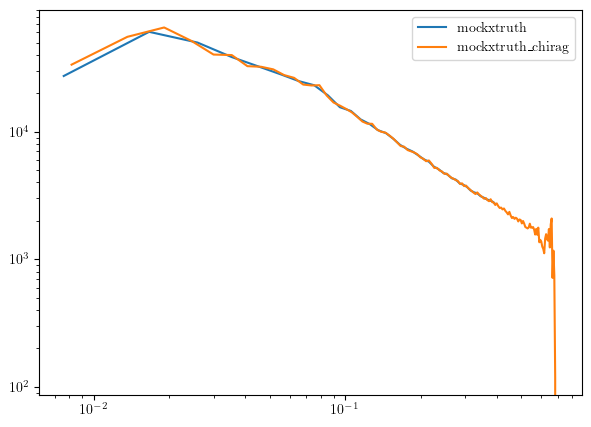

In [17]:
pl.figure(figsize=(7,5))
# pl.plot(Pk_orig_nb['k'], Pk_orig_nb['power'].real, label='orig')
# pl.plot(Pk_truth_vox_nb['k'], Pk_truth_vox_nb['power'].real, label='truth_vox')
# pl.plot(Pk_mock_nb['k'], Pk_mock_nb['power'].real, label='mock')
pl.plot(Pk_mockxtruth_nb['k'], Pk_mockxtruth_nb['power'].real, label='mockxtruth')
# pl.plot(k_orig_chirag, Pk_orig_chirag, label='orig_chirag')
# pl.plot(k_truth_vox_chirag, Pk_truth_vox_chirag, label='truth_vox_chirag')
# pl.plot(k_mock_chirag, Pk_mock_chirag, label='mock_chirag')
pl.plot(k_mockxtruth_chirag, Pk_mockxtruth_chirag, label='mockxtruth_chirag')
pl.legend()
pl.xscale('log')
pl.yscale('log')


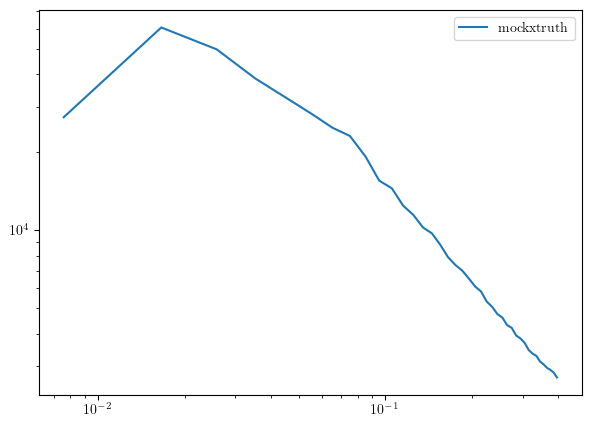

In [18]:
pl.figure(figsize=(7,5))
# pl.plot(Pk_orig_nb['k'], Pk_orig_nb['power'].real, label='orig')
# pl.plot(Pk_truth_vox_nb['k'], Pk_truth_vox_nb['power'].real, label='truth_vox')
# pl.plot(Pk_mock_nb['k'], Pk_mock_nb['power'].real, label='mock')
pl.plot(Pk_mockxtruth_nb['k'], Pk_mockxtruth_nb['power'].real, label='mockxtruth')
# pl.plot(k_orig_chirag, Pk_orig_chirag, label='orig_chirag')
# pl.plot(k_truth_vox_chirag, Pk_truth_vox_chirag, label='truth_vox_chirag')
# pl.plot(k_mock_chirag, Pk_mock_chirag, label='mock_chirag')
# pl.plot(k_mockxtruth_chirag, Pk_mockxtruth_chirag, label='mockxtruth_chirag')
pl.legend()
pl.xscale('log')
pl.yscale('log')


Text(0.5, 0, '$k$ [$h$/Mpc]')

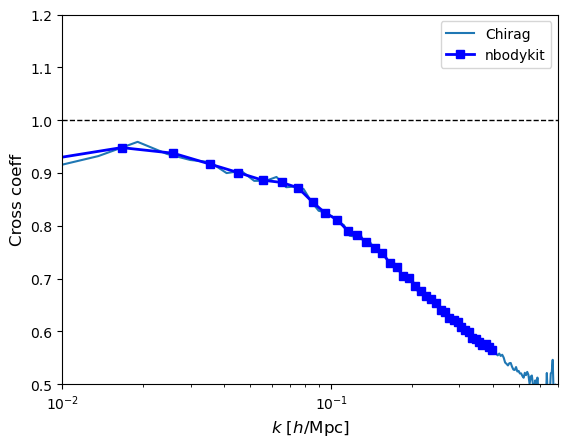

In [19]:
pl.figure()
pl.plot(k_mockxtruth_chirag, Pk_mockxtruth_chirag/(np.sqrt(Pk_truth_vox_chirag * Pk_mock_chirag)), label='Chirag')
# pl.plot(Pk_mockxtruth.k3D, (Pk_mockxtruth.Pk[:,0,0]) / (((Pk_mock.Pk[:,0]) * (Pk_truth.Pk[:,0])) ** 0.5), label='Pylians', color='b', ls='-', marker='s', lw=2.0)
pl.plot(Pk_mockxtruth_nb['k'], (Pk_mockxtruth_nb['power'].real) / (((Pk_truth_vox_nb['power'].real) * (Pk_mock_nb['power'].real)) ** 0.5), label='nbodykit', color='b', ls='-', marker='s', lw=2.0)
pl.ylim(0.5, 1.2)
pl.xlim(0.01,0.7)
pl.xscale('log')
pl.legend()
pl.axhline(1.0, color='k', ls='--', lw=1)
pl.ylabel('Cross coeff',size=12)
pl.xlabel(r'$k$ [$h$/Mpc]', size=12)


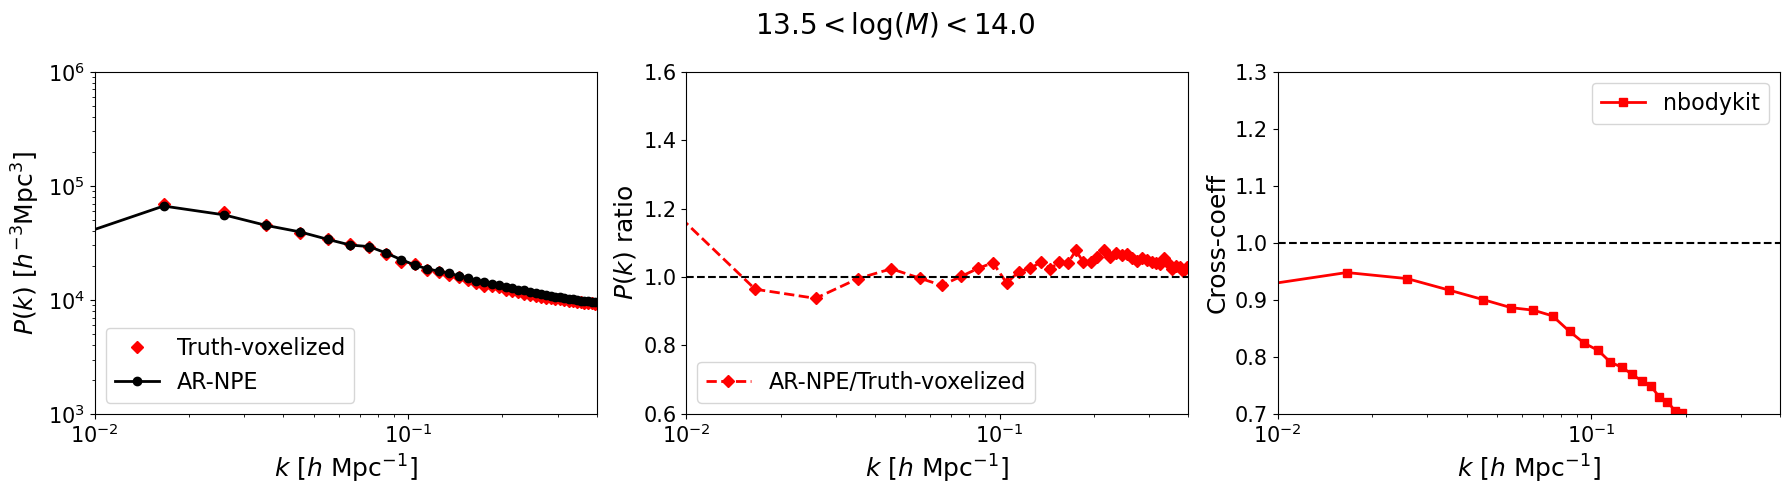

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
# First subplot
# axes[0].loglog(Pk_truth.k3D, Pk_truth.Pk[:,0], label='Truth', color='b', ls='', marker='s', lw=2.0)
# axes[0].loglog(Pk_truth2.k3D, Pk_truth2.Pk[:,0], label='Truth-voxelized', color='r', ls='', marker='D', lw=2.0)
# axes[0].loglog(Pk_mock.k3D, Pk_mock.Pk[:,0], label='AR-NPE', color='k', ls='-', marker='o', lw=2.0)
# axes[0].set_ylim(1e3, 1e5)
axes[0].set_ylim(1e3, 1e6)

# axes[0].loglog(Pk_orig_nb['k'], Pk_orig_nb['power'].real, label='Truth', color='b', ls='', marker='s', lw=2.0)
axes[0].loglog(Pk_truth_vox_nb['k'], Pk_truth_vox_nb['power'].real, label='Truth-voxelized', color='r', ls='', marker='D', lw=2.0)
axes[0].loglog(Pk_mock_nb['k'], (Pk_mock_nb['power'].real), label='AR-NPE', color='k', ls='-', marker='o', lw=2.0)

axes[0].legend(fontsize=16, loc='lower left')
# axes[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=22)
axes[0].set_ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]", size=18)
# axes[0].set_title(str(Mmin_Pk) + r'$< \log(M) <$' + str(Mmax_Pk), size=18)
axes[0].tick_params(axis='both', labelsize=15)
# Second subplot
# axes[1].plot(Pk_mock_nb['k'], (Pk_mock_nb['power'].real) / (Pk_orig_nb['power'].real), label='AR-NPE/Truth', color='b', ls='-', marker='o', lw=2.0)
axes[1].plot(Pk_mock_nb['k'], (Pk_mock_nb['power'].real) / (Pk_truth_vox_nb['power'].real), label='AR-NPE/Truth-voxelized', color='r', ls='--', marker='D', lw=2.0)

# axes[1].plot(Pk_mock.k3D, Pk_mock.Pk[:,0]/ Pk_truth.Pk[:,0], label='AR-NPE/Truth', color='b', ls='-', marker='o', lw=2.0)
# axes[1].plot(Pk_mock.k3D, Pk_mock.Pk[:,0]/ Pk_truth2.Pk[:,0], label='AR-NPE/Truth-voxelized', color='r', ls='--', marker='D', lw=2.0)


axes[1].legend(fontsize=16, loc='lower left')
# axes[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=22)
axes[1].set_ylabel(r"$P(k)$ ratio", size=18)
axes[1].axhline(1.0, ls='--', color='k')
# axes[1].set_ylim(0.8, 1.2)
axes[1].set_ylim(0.6, 1.6)
axes[1].tick_params(axis='both', labelsize=15)


# Third subplot
# axes[2].plot(Pk_mockxtruth['k'], (Pk_mockxtruth['power'].real) / (((Pk_mock['power'].real) * (Pk_truth['power'].real)) ** 0.5), label='Truth x AR-NPE', color='b', ls='-', marker='s', lw=2.0)
# axes[2].plot(Pk_mockxtruth2['k'], (Pk_mockxtruth2['power'].real) / (((Pk_mock['power'].real) * (Pk_truth2['power'].real)) ** 0.5), label='Truth-voxelized x AR-NPE', color='r', ls='--', marker='D', lw=2.0)
# axes[2].plot(Pk_mockxtruth.k3D, (Pk_mockxtruth.Pk[:,0,0]) / (((Pk_mock.Pk[:,0]) * (Pk_truth.Pk[:,0])) ** 0.5), label='Truth x AR-NPE', color='b', ls='-', marker='s', lw=2.0)
# axes[2].plot(Pk_mockxtruth_nb['k'], (Pk_mockxtruth_nb['power'].real) / (((Pk_truth_vox_nb['power'].real) * (Pk_mock_nb['power'].real)) ** 0.5), label='nbodykit', color='b', ls='-', marker='s', lw=2.0)
axes[2].plot(Pk_mockxtruth_nb['k'], (Pk_mockxtruth_nb['power'].real) / (((Pk_truth_vox_nb['power'].real)  * (Pk_mock_nb['power'].real)) ** 0.5), label='nbodykit', color='r', ls='-', marker='s', lw=2.0)


# axes[2].plot(Pk_truthxtruth2['k'], (Pk_truthxtruth2['power'].real) / (((Pk_truth['power'].real) * (Pk_truth2['power'].real)) ** 0.5), label='Truth-voxelized x AR-NPE', color='r', ls='--', marker='s', lw=2.0)
# axes[2].set_ylim(0.9, 1.1)
axes[2].set_ylim(0.7, 1.3)
axes[2].axhline(1.0, ls='--', color='k')
axes[2].set_xscale('log')
axes[2].legend(fontsize=16)
axes[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=18)
axes[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=18)
axes[2].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=18)
axes[2].set_ylabel(r"Cross-coeff", size=18)
axes[2].tick_params(axis='both', labelsize=15)
axes[2].set_xlim(0.01, 0.4)
plt.suptitle(str(lgM_min) + r'$< \log(M) <$' + str(lgM_max), size=20)
plt.tight_layout()
# plt.savefig('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/figs/power_comp_ns_' + str(ns_h) + '_lgM' + str(Mmin_Pk) + '_' + str(Mmax_Pk) + '.png', dpi=300) 
# plt.savefig('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/figs/power_comp_ns_' + str(ns_h) + '_lgM' + str(Mmin_Pk) + '_' + str(Mmax_Pk) + '.png', dpi=300) 


                   

In [21]:
saved = {}
saved['onep_delta_mock'] = onep_delta_mock
saved['onep_delta_truth_vox'] = onep_delta_truth_vox
saved['onep_delta_orig'] = onep_delta_orig
saved['k_Pkorig']  = Pk_orig_nb['k']
saved['Pkorig']  = Pk_orig_nb['power'].real
saved['k_Pktruth_vox']  = Pk_truth_vox_nb['k']
saved['Pktruth_vox']  = Pk_truth_vox_nb['power'].real
saved['k_Pkmock']  = Pk_mock_nb['k']
saved['Pkmock']  = Pk_mock_nb['power'].real
saved['k_Pkmockxtruth']  = Pk_mockxtruth_nb['k']
saved['Pkmockxtruth']  = Pk_mockxtruth_nb['power'].real
import pickle as pk
pk.dump(saved, open('save_nbodykit_test_data.pk','wb'))



In [2]:
# import MAS_library as MASL
import sys, os
from tqdm import tqdm
import readfof
import numpy as np
import pickle as pk 
# from nbodykit.lab import *
import h5py as h5
import numpy as np
import Pk_library as PKL
import MAS_library as MASL





In [3]:
saved = pk.load(open('save_nbodykit_test_data.pk','rb'))
onep_delta_mock = saved['onep_delta_mock']
onep_delta_truth_vox = saved['onep_delta_truth_vox']
onep_delta_orig = saved['onep_delta_orig']
k_Pkorig = saved['k_Pkorig']
Pkorig = saved['Pkorig']
k_Pktruth_vox = saved['k_Pktruth_vox']
Pktruth_vox = saved['Pktruth_vox']
k_Pkmock = saved['k_Pkmock']
Pkmock = saved['Pkmock']
k_Pkmockxtruth = saved['k_Pkmockxtruth']
Pkmockxtruth = saved['Pkmockxtruth']

In [4]:
BoxSize = 1000.0
Pk_orig_py = PKL.Pk(onep_delta_orig-1, BoxSize, axis=0, MAS=None, threads=1)
Pk_truth_vox_py = PKL.Pk(onep_delta_truth_vox-1, BoxSize, axis=0, MAS=None, threads=1)
Pk_mock_py = PKL.Pk(onep_delta_mock-1, BoxSize, axis=0, MAS=None, threads=1)
Pk_mockxtruth_py = PKL.XPk([onep_delta_mock-1, onep_delta_truth_vox-1], BoxSize, axis=0, MAS=[None,None], threads=1)




Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.03
Time loop = 0.04
Time taken = 0.07 seconds


In [5]:
# BoxSize = 1000.0
# MAS = 'NGP'
# Pk_orig_py = PKL.Pk(onep_delta_orig-1, BoxSize, axis=0, MAS=MAS, threads=1)
# Pk_truth_vox_py = PKL.Pk(onep_delta_truth_vox-1, BoxSize, axis=0, MAS=MAS, threads=1)
# Pk_mock_py = PKL.Pk(onep_delta_mock-1, BoxSize, axis=0, MAS=MAS, threads=1)
# Pk_mockxtruth_py = PKL.XPk([onep_delta_mock-1, onep_delta_truth_vox-1], BoxSize, axis=0, MAS=[MAS,MAS], threads=1)



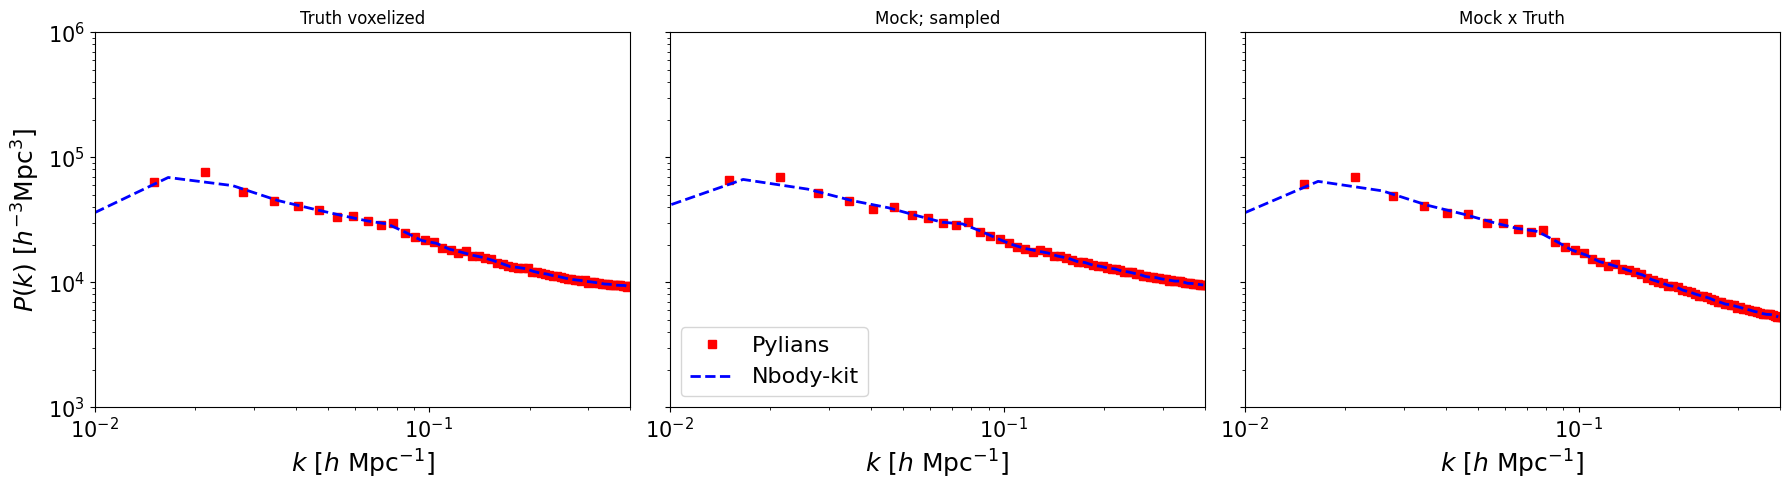

In [6]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
axes[0].set_ylim(1e3, 1e6)

# axes[0].loglog(Pk_orig_py.k3D, Pk_orig_py.Pk[:,0], label='Truth', color='b', ls='', marker='s', lw=2.0)
# axes[0].loglog(k_Pkorig, Pkorig, label='Truth', color='b', ls='--', marker='s', lw=2.0)

axes[0].loglog(Pk_truth_vox_py.k3D, Pk_truth_vox_py.Pk[:,0], label='Pylians', color='r', ls='', marker='s', lw=2.0)
axes[0].loglog(k_Pktruth_vox, Pktruth_vox, label='Nbody-kit', color='b', ls='--', marker='', lw=2.0)
axes[0].set_title('Truth voxelized')
# axes[0].legend(fontsize=16, loc='lower left')
# axes[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=22)
axes[0].set_ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]", size=18)
# axes[0].set_title(str(Mmin_Pk) + r'$< \log(M) <$' + str(Mmax_Pk), size=18)
axes[0].tick_params(axis='both', labelsize=15)
# Second subplot
# axes[1].plot(Pk_mock_nb['k'], (Pk_mock_nb['power'].real) / (Pk_orig_nb['power'].real), label='AR-NPE/Truth', color='b', ls='-', marker='o', lw=2.0)
# axes[1].plot(Pk_mock_nb['k'], (Pk_mock_nb['power'].real) / (Pk_truth_vox_nb['power'].real), label='AR-NPE/Truth-voxelized', color='r', ls='--', marker='D', lw=2.0)

axes[1].loglog(Pk_mock_py.k3D, Pk_mock_py.Pk[:,0], label='Pylians', color='r', ls='', marker='s', lw=2.0)
axes[1].loglog(k_Pkmock, Pkmock, label='Nbody-kit', color='b', ls='--', marker='', lw=2.0)

axes[1].set_title('Mock; sampled')
axes[1].legend(fontsize=16, loc='lower left')
# axes[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=22)
# axes[1].set_ylabel(r"$P(k)$ ratio", size=18)
# axes[1].axhline(1.0, ls='--', color='k')
# axes[1].set_ylim(0.8, 1.2)
# axes[1].set_ylim(0.6, 1.6)
axes[1].tick_params(axis='both', labelsize=15)


# Third subplot
axes[2].loglog(Pk_mockxtruth_py.k3D, Pk_mockxtruth_py.XPk[:,0,0], label='Pylians', color='r', ls='', marker='s', lw=2.0)
axes[2].loglog(k_Pkmockxtruth, Pkmockxtruth, label='Nbody-kit', color='b', ls='--', marker='', lw=2.0)

axes[2].set_title('Mock x Truth')
# axes[2].plot(Pk_truthxtruth2['k'], (Pk_truthxtruth2['power'].real) / (((Pk_truth['power'].real) * (Pk_truth2['power'].real)) ** 0.5), label='Truth-voxelized x AR-NPE', color='r', ls='--', marker='s', lw=2.0)
# axes[2].set_ylim(0.9, 1.1)
# axes[2].set_ylim(0.7, 1.3)
# axes[2].axhline(1.0, ls='--', color='k')
axes[2].set_xscale('log')
# axes[2].legend(fontsize=16)
axes[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=18)
axes[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=18)
axes[2].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=18)
# axes[2].set_ylabel(r"Cross-coeff", size=18)
axes[2].tick_params(axis='both', labelsize=15)
axes[2].set_xlim(0.01, 0.4)
# plt.suptitle(str(lgM_min) + r'$< \log(M) <$' + str(lgM_max), size=20)
plt.tight_layout()
# plt.savefig('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/figs/power_comp_ns_' + str(ns_h) + '_lgM' + str(Mmin_Pk) + '_' + str(Mmax_Pk) + '.png', dpi=300) 
# plt.savefig('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/figs/power_comp_ns_' + str(ns_h) + '_lgM' + str(Mmin_Pk) + '_' + str(Mmax_Pk) + '.png', dpi=300) 


                   



Text(0.5, 1.0, 'AR-NPE')

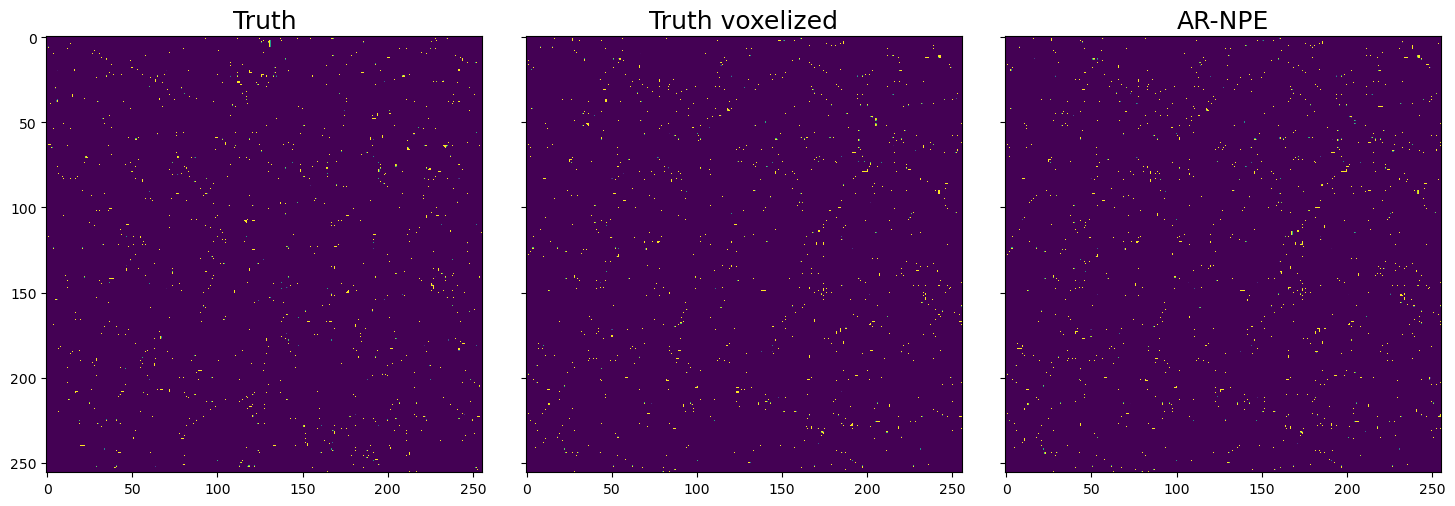

In [130]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))), vmin=-1.0, vmax=200.0)
# axes[0].imshow(np.log((onep_delta_orig[64,...])), vmin=0.0, vmax=200.0)
axes[0].imshow(np.log((onep_delta_orig[64,...] + 1e-5)), vmin=0.0, vmax=1.0)
axes[0].set_title('Truth', size=18)
# axes[0].imshow(((mesh_mock.preview(axes=[0,1]) - mesh_truth2.preview(axes=[0,1]))), vmin=-1.0, vmax=200.0)
# axes[0].set_title('AR-NPE', size=18)

# axes[1].imshow(((mesh_truth2.preview(axes=[0,1]))), vmin=-1.0, vmax=200.0)
axes[1].imshow(np.log((onep_delta_truth_vox[64,...] + 1e-5)), vmin=0.0, vmax=1.0)
axes[1].set_title('Truth voxelized', size=18)
# axes[2].imshow(((mesh_mock.preview(axes=[0,1]))), vmin=-1.0, vmax=200.0)
axes[2].imshow(np.log((onep_delta_mock[64,...] + 1e-5)), vmin=0.0, vmax=1.0)
axes[2].set_title('AR-NPE', size=18)






In [1]:
# np.log((onep_delta_orig[64,...] + 1e-5)).min(), np.log((onep_delta_orig[64,...] + 1e-5)).max()


In [2]:
# pl.figure()
# _ = pl.hist(np.log(onep_delta_mock+1e-5).flatten(), bins=100, histtype='step', label='AR-NPE')
# pl.yscale('log')


In [3]:
# pl.figure()
# pl.imshow(onep_delta_truth_vox[:,:,32])
